## Import library dan load data

In [84]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

In [85]:
df = pd.read_csv('goto_stock.csv')

df = df[['Date', 'Close']]

df

,Date,Close
0,2023-01-02,93.0
1,2023-01-03,95.0
2,2023-01-04,96.0
3,2023-01-05,92.0
4,2023-01-06,95.0
...,...,...
557,2025-05-15,73.0
558,2025-05-16,73.0
559,2025-05-19,71.0
560,2025-05-20,72.0


Pada penelitian ini hanya menggunakan kolom Date dan Close untuk memprediksi harga saham PT GOTO.

Dataset tersebut dapat diakses melalui URL berikut : "https://finance.yahoo.com/quote/GOTO.JK/"

## Analisis data

In [86]:
df[['Date']] = df[['Date']].apply(pd.to_datetime)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 562 entries, 0 to 561
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    562 non-null    datetime64[ns]
 1   Close   562 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 8.9 KB


In [87]:
df.describe()

,Date,Close
count,562,562.000000
mean,2024-03-08 13:42:29.466192384,82.912811
min,2023-01-02 00:00:00,50.000000
25%,2023-08-09 06:00:00,67.000000
50%,2024-03-04 12:00:00,81.000000
75%,2024-10-09 18:00:00,94.750000
max,2025-05-21 00:00:00,147.000000
std,NaN,21.066008


In [88]:
# Periksa Missing Value
print("Missing Values:\n", df.isnull().sum())
print("\nTotal Missing Values:", df.isnull().sum().sum())

# Periksa Duplikasi
duplicates = df.duplicated()
print("\nJumlah data duplikat:", duplicates.sum())
if duplicates.sum() > 0:
    print("\nContoh data duplikat:")
    print(df[duplicates].head())

# Periksa Outlier dengan Interquartile Range (IQR)
numeric_cols = df.select_dtypes(include=['float64', 'int64'])
# Inisialisasi dictionary untuk menyimpan jumlah outlier per kolom
outliers_iqr = {}
for col in numeric_cols.columns:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    # Kondisi outlier: nilai < Q1 - 1.5*IQR atau > Q3 + 1.5*IQR
    is_outlier = (df[col] < (Q1 - 1.5 * IQR)) | (df[col] > (Q3 + 1.5 * IQR))
    # Simpan jumlah outlier
    outliers_iqr[col] = is_outlier.sum()
print("\nJumlah outlier (metode IQR) per kolom numerik:\n")
for col, count in outliers_iqr.items():
    print(f"{col}: {count}")

Missing Values:
 Date     0
Close    0
dtype: int64

Total Missing Values: 0

Jumlah data duplikat: 0

Jumlah outlier (metode IQR) per kolom numerik:

Close: 1


Dataset ini terdiri dari 562 entri dengan dua kolom utama, yaitu Date dan Close tanpa adanya missing value dan duplikasi, tetapi terdapat satu outlier. Kolom Date telah berhasil dikonversi ke format datetime64[ns], sementara kolom Close bertipe float64. Berdasarkan hasil analisis deskriptif, nilai penutupan (Close) memiliki rata-rata sebesar 82.91, dengan nilai minimum 50 dan maksimum 147. Distribusi nilai Close menunjukkan bahwa 25% data berada di bawah 67, 50% (median) di bawah 81, dan 75% di bawah 94.75. Penyebaran data Close ditunjukkan oleh nilai standar deviasi sebesar 21.07. Data ini mencakup rentang waktu dari 2 Januari 2023 hingga 21 Mei 2025.

## Preprocessing

Pada bagian ini akan, mengatasi outlier menggunakan nilai median sebagai ganti dari data outlier

In [89]:
# Handle Outlier dengan Median (IQR method)
for col in numeric_cols.columns:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    median = df[col].median()
    
    # Ganti outlier dengan median
    df[col] = df[col].apply(lambda x: median if x < lower_bound or x > upper_bound else x)

In [90]:
# Periksa Outlier dengan Interquartile Range (IQR)
numeric_cols = df.select_dtypes(include=['float64', 'int64'])
# Inisialisasi dictionary untuk menyimpan jumlah outlier per kolom
outliers_iqr = {}
for col in numeric_cols.columns:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    # Kondisi outlier: nilai < Q1 - 1.5*IQR atau > Q3 + 1.5*IQR
    is_outlier = (df[col] < (Q1 - 1.5 * IQR)) | (df[col] > (Q3 + 1.5 * IQR))
    # Simpan jumlah outlier
    outliers_iqr[col] = is_outlier.sum()
print("\nJumlah outlier (metode IQR) per kolom numerik:\n")
for col, count in outliers_iqr.items():
    print(f"{col}: {count}")


Jumlah outlier (metode IQR) per kolom numerik:

Close: 0


Pada bagian di bawah ini, data time series diubah ke dalam format windowed input yang umum digunakan pada pemodelan time series supervised learning. Fungsi prepare_train_df menerima data_series dan parameter data_input, yang menentukan panjang jendela (window) input. Dalam kasus ini, panjang window ditetapkan sebesar 6, artinya setiap baris data pelatihan terdiri dari 6 nilai sebelumnya (x1 hingga x6) untuk memprediksi nilai berikutnya (y).

Setelah data dibentuk menjadi format window, dilakukan proses normalisasi menggunakan MinMaxScaler untuk mengubah nilai Close ke dalam rentang [0, 1]. Hal ini penting agar model pembelajaran mesin dapat bekerja secara optimal dan tidak bias terhadap skala data.

Sebagai hasil, train_df adalah DataFrame baru dengan struktur yang siap digunakan untuk pelatihan model, di mana kolom x1 hingga x6 merupakan fitur, dan y adalah target yang ingin diprediksi.

In [91]:
# Mengubah menjadi windows format berdasarkan teori pada time series data
def prepare_train_df(data_series, data_input=6):
    X, y = [], []

    for i in range(len(data_series) - data_input):
        X.append(data_series[i:i + data_input].flatten())  # Gunakan flatten/ravel
        y.append(data_series[i + data_input][0])  # Ambil angka scalar

    X_df = pd.DataFrame(X, columns=[f'x{i+1}' for i in range(data_input)])
    y_df = pd.Series(y, name='y')

    train_df = pd.concat([X_df, y_df], axis=1)
    return train_df

data_series = df['Close'].values.reshape(-1, 1)

# Normalisasi
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data_series)

train_df = prepare_train_df(data_scaled, data_input=6)
print("Bentuk data setelah transformasi : ")
train_df

Bentuk data setelah transformasi : 


,x1,x2,x3,x4,x5,x6,y
0,0.5375,0.5625,0.5750,0.5250,0.5625,0.5375,0.5625
1,0.5625,0.5750,0.5250,0.5625,0.5375,0.5625,0.5500
2,0.5750,0.5250,0.5625,0.5375,0.5625,0.5500,0.5875
3,0.5250,0.5625,0.5375,0.5625,0.5500,0.5875,0.6875
4,0.5625,0.5375,0.5625,0.5500,0.5875,0.6875,0.7125
...,...,...,...,...,...,...,...
551,0.4125,0.4125,0.4250,0.3875,0.3875,0.3625,0.2875
552,0.4125,0.4250,0.3875,0.3875,0.3625,0.2875,0.2875
553,0.4250,0.3875,0.3875,0.3625,0.2875,0.2875,0.2625
554,0.3875,0.3875,0.3625,0.2875,0.2875,0.2625,0.2750


Setelah data pelatihan (train_df) terbentuk, langkah selanjutnya adalah memisahkan fitur (X) dan target (y). Kolom y berisi nilai yang akan diprediksi, sementara kolom x1 hingga x6 digunakan sebagai input.

Kemudian, data fitur X di-reshape menjadi format 3 dimensi dengan struktur (samples, timesteps, features), yaitu format yang umum digunakan untuk model time series, timesteps bernilai 6 (panjang window), dan features adalah 1 karena hanya ada satu variabel input.

Selanjutnya, data dibagi menjadi data pelatihan dan data pengujian dengan rasio 80:20. Ini penting untuk mengevaluasi performa model dengan data yang tidak pernah dilihat sebelumnya.

Sebagai verifikasi, ditampilkan bentuk (shape) dari X_test, yang menunjukkan bahwa terdapat 112 sampel, masing-masing terdiri dari 6 langkah waktu dengan 1 fitur.


In [92]:
# Pisahkan fitur (X) dan target (y)
X = train_df.drop(columns='y').values
y = train_df['y'].values

# Reshape X menjadi (samples, timesteps, features)
X = X.reshape((X.shape[0], X.shape[1], 1))

# Split data
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Print X_test untuk melihat hasil
X_test.shape


(112, 6, 1)

## Modelling

Pada bagian ini, dibangun sebuah model jaringan saraf LSTM (Long Short-Term Memory) untuk melakukan prediksi berdasarkan data time series yang telah diproses sebelumnya. Model menggunakan arsitektur Sequential dengan struktur sebagai berikut:
- LSTM layer pertama dengan 100 unit dan return_sequences=True agar mengembalikan urutan penuh, dibutuhkan untuk input ke LSTM selanjutnya.
- Dropout layer untuk mencegah overfitting.
- LSTM layer kedua dengan 80 unit dan return_sequences=False, karena ini adalah LSTM terakhir.
- Dropout layer tambahan.
- Dense layer dengan 50 unit dan aktivasi ReLU sebagai lapisan fully-connected.
- Dropout tambahan sebelum output.
- Dense output layer dengan 1 unit untuk regresi nilai Close berikutnya.

Model dikompilasi menggunakan:
- Loss function: Mean Squared Error (MSE), umum untuk regresi.
- Optimizer: Adam, yang adaptif dan efisien.
- Metric evaluasi: Mean Absolute Error (MAE), yang lebih mudah diinterpretasikan dalam satuan aslinya.

Model dilatih selama 100 epoch dengan batch size 16, menggunakan data validasi dari X_test dan y_test.
Setelah pelatihan selesai, model dievaluasi dan hasil MAE pada data uji ditampilkan. Nilai MAE ini menunjukkan rata-rata kesalahan absolut antara prediksi dan nilai aktual.

In [93]:
model = Sequential()
model.add(LSTM(100, return_sequences=True, input_shape=(6, 1), activation='tanh')) 
model.add(Dropout(0.2))  
model.add(LSTM(80, return_sequences=False, activation='tanh'))  
model.add(Dropout(0.2))
model.add(Dense(50, activation='relu'))  
model.add(Dropout(0.1)) 
model.add(Dense(1)) 

model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae']) 

# Latih model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=16, verbose=1)

loss, mae = model.evaluate(X_test, y_test, verbose=0)
print(f"Test MAE: {mae:.2f}")

Epoch 1/100


c:\Users\hp\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


28/28 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 0.1072 - mae: 0.2324 - val_loss: 0.0036 - val_mae: 0.0468
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0128 - mae: 0.0857 - val_loss: 0.0032 - val_mae: 0.0443
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0077 - mae: 0.0646 - val_loss: 0.0030 - val_mae: 0.0434
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0075 - mae: 0.0643 - val_loss: 0.0028 - val_mae: 0.0406
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0096 - mae: 0.0724 - val_loss: 0.0036 - val_mae: 0.0474
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0075 - mae: 0.0634 - val_loss: 0.0026 - val_mae: 0.0386
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0069 - mae: 0.0623 - val_loss: 0.0028 - val_mae: 0.0415
Epoch 8/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0079 - mae: 0.0629 - val_loss: 0.0028 - val_mae: 0.0405
Epoch 9/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0083 - mae: 0.

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


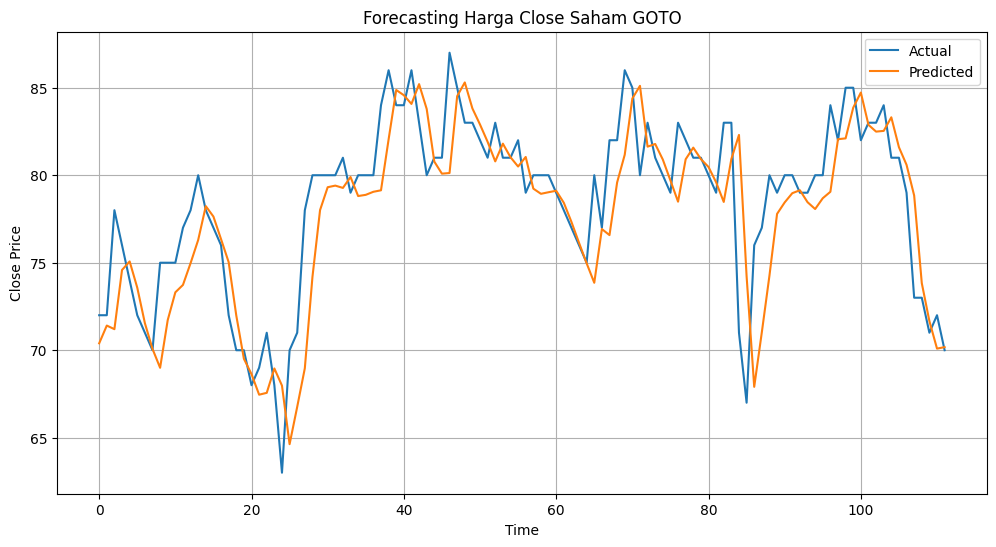

In [94]:
# Prediksi dan balikkan skala
y_pred = model.predict(X_test)
y_pred_inv = scaler.inverse_transform(y_pred)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

# Visualisasi
plt.figure(figsize=(12, 6))
plt.plot(y_test_inv, label='Actual')
plt.plot(y_pred_inv, label='Predicted')
plt.title("Forecasting Harga Close Saham GOTO")
plt.xlabel("Time")
plt.ylabel("Close Price")
plt.legend()
plt.grid(True)
plt.show()

Grafik di atas menunjukkan hasil prediksi harga penutupan (Close Price) saham GOTO menggunakan model LSTM yang telah dilatih.

- Garis biru mewakili harga aktual (Actual) dari data uji.
- Garis oranye menunjukkan harga yang diprediksi (Predicted) oleh model.

Dari visualisasi tersebut, dapat disimpulkan bahwa:

1. Model mampu mengikuti tren umum harga saham dengan cukup baik. Pola naik-turun dari harga aktual berhasil diikuti oleh prediksi, meskipun dengan beberapa deviasi.
2. Pada beberapa bagian, seperti di sekitar titik ke-40 dan ke-80, prediksi sedikit tertinggal atau mendatar saat harga aktual mengalami fluktuasi tajam. Hal ini umum terjadi pada model time series ketika menghadapi volatilitas yang tinggi.
3. Tingkat kedekatan prediksi dan nilai aktual menunjukkan bahwa model berhasil belajar hubungan temporal dari data historis dengan baik, walaupun masih terdapat potensi peningkatan, misalnya dengan tuning parameter, menambah data, atau mencoba arsitektur lain.

Secara keseluruhan, hasil forecasting ini menunjukkan bahwa LSTM adalah pendekatan yang cukup efektif untuk memodelkan dan memprediksi pergerakan harga saham berbasis time series.

In [95]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
mae = mean_absolute_error(y_test_inv, y_pred_inv)
print(f"RMSE pada data pengujian: {rmse:.2f}")
print(f"MAE pada data pengujian: {mae:.2f}")

RMSE pada data pengujian: 3.12
MAE pada data pengujian: 2.18


Setelah melakukan prediksi harga saham GOTO, model dievaluasi menggunakan dua metrik regresi yang umum digunakan, yaitu:

- RMSE (Root Mean Squared Error): 3.12
- MAE (Mean Absolute Error): 2.18

Interpretasi:

- MAE menunjukkan bahwa secara rata-rata, prediksi model meleset sebesar 2.18 poin dari nilai aktual. Karena MAE bersifat linier, metrik ini mudah diinterpretasikan dan tidak terlalu dipengaruhi oleh outlier.
- RMSE, yang merupakan akar dari MSE, memiliki nilai sedikit lebih tinggi karena memberikan penalti lebih besar terhadap kesalahan yang besar. Nilai RMSE sebesar 3.12 masih tergolong rendah jika dibandingkan dengan rentang harga saham yang diamati.

Secara keseluruhan, nilai RMSE dan MAE yang cukup kecil ini menunjukkan bahwa model LSTM mampu memberikan hasil prediksi yang akurat dan layak untuk digunakan sebagai dasar analisis pergerakan harga saham GOTO.

## Forecasting untuk 30 hari kedepan

Pada bagian ini, dilakukan proses forecasting (prediksi) harga saham GOTO untuk 30 hari ke depan menggunakan pendekatan iteratif berdasarkan model LSTM yang telah dilatih sebelumnya. Pendekatan ini bekerja dengan memanfaatkan prediksi sebelumnya sebagai input untuk memprediksi hari berikutnya.

Langkah-langkah utama:
- Mengambil urutan data terakhir dari X_test sebagai titik awal prediksi.
- Menggunakan model untuk menghasilkan satu prediksi pada satu waktu.
- Menambahkan prediksi tersebut ke dalam input_seq agar bisa digunakan pada iterasi selanjutnya.
- Setelah proses selesai, hasil prediksi dikembalikan ke skala asli (detransformasi) menggunakan fungsi inverse dari MinMaxScaler.

Output dari proses ini adalah deret harga prediksi untuk 30 hari ke depan. Hasil ini sangat berguna untuk analisis lebih lanjut seperti strategi investasi jangka pendek, identifikasi tren harga, maupun pengambilan keputusan bisnis berbasis data.

In [96]:
# Forecast 30 hari ke depan secara iteratif
forecast_steps = 30
input_seq = X_test[-1]
predictions = []

for _ in range(forecast_steps):
    pred = model.predict(input_seq.reshape(1, 6, 1))
    predictions.append(pred[0,0])
    # Update input_seq dengan nilai prediksi, hapus data paling awal
    input_seq = np.append(input_seq[1:], pred[0,0])
    
# Inverse transform hasil prediksi ke skala asli
predictions = scaler.inverse_transform(np.array(predictions).reshape(-1,1))

print("Forecast 10 hari ke depan:", predictions.flatten())

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━

## Visualisasi hasil

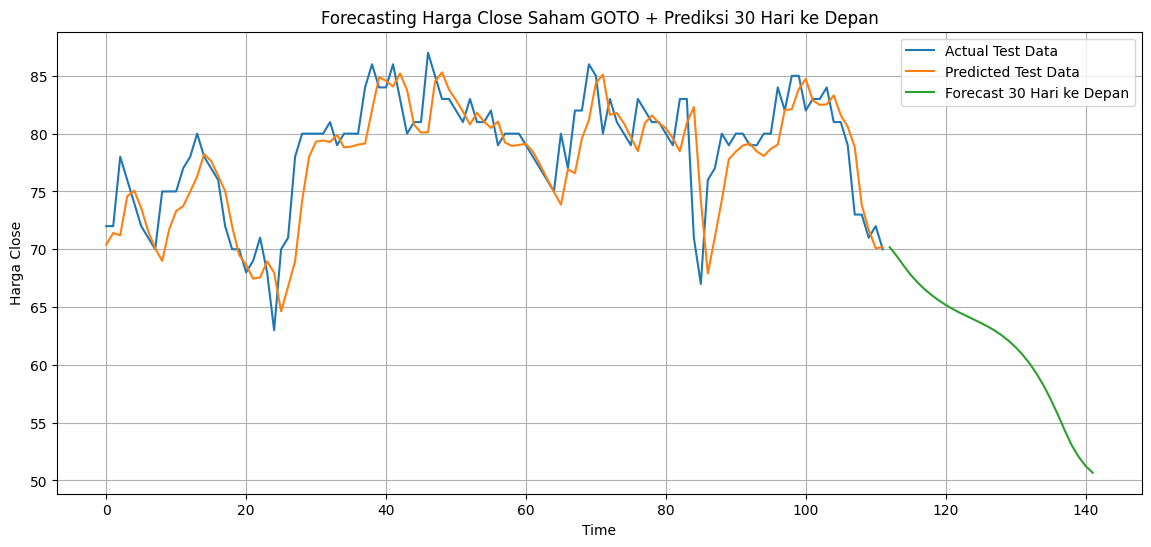

In [97]:
# Plot hasil test dan prediksi test
plt.figure(figsize=(14,6))
plt.plot(y_test_inv, label='Actual Test Data')
plt.plot(y_pred_inv, label='Predicted Test Data')

# Plot forecast 30 hari ke depan, mulai dari setelah data test
forecast_start = len(y_test_inv)
forecast_end = forecast_start + len(predictions)

plt.plot(range(forecast_start, forecast_end), predictions, label='Forecast 30 Hari ke Depan', linestyle='-')

plt.title("Forecasting Harga Close Saham GOTO + Prediksi 30 Hari ke Depan")
plt.xlabel("Time")
plt.ylabel("Harga Close")
plt.legend()
plt.grid(True)
plt.show()


1. Data Aktual vs Prediksi pada Data Uji
- Garis Biru (Actual Test Data): Menampilkan harga penutupan (Close Price) saham GOTO yang sesungguhnya pada data uji.
- Garis Oranye (Predicted Test Data): Menampilkan hasil prediksi model LSTM terhadap data uji.
- Dari visualisasi ini terlihat bahwa model cukup mampu mengikuti pola naik-turun harga saham meskipun dengan sedikit deviasi. Hal ini menunjukkan bahwa model memiliki generalisasi yang cukup baik terhadap pola historis data.

2. Prediksi 30 Hari ke Depan
- Garis Hijau (Forecast 30 Hari ke Depan): Merupakan prediksi harga saham untuk 30 hari ke depan berdasarkan pendekatan iteratif dari model.
- Terlihat bahwa harga saham diprediksi mengalami penurunan dan kemudian menjadi relatif stabil di sekitar nilai rendah tertentu. Ini menunjukkan bahwa model "menganggap" harga akan menurun dan mengalami konsolidasi.